In [199]:
import lasagne
import theano
import theano.tensor as T
import numpy as np
from scipy.io import loadmat
import matplotlib.pylab as plt
%matplotlib inline
from IPython import display
import time

import numpy as np
import theano
import theano.tensor as T
from lasagne import nonlinearities
from lasagne import init
from lasagne.utils import unroll_scan

from lasagne.layers import MergeLayer, Layer
from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import helper

Make sure we generate the same data every time by fixing the seed

In [200]:
np.random.seed(42)

Data is the (x,y) position of a ball as it ricochets around in a box of size (xmin,xmax,ymin,ymax)

In [201]:
xmin,xmax,ymin,ymax = (-1,1,-1,1)
lower_bound = np.array([xmin,ymin])
upper_bound = np.array([xmax,ymax])

ndims = 2
nsteps = 100
nsequences = 10

def bounce_ball(pos,vel):
    for n in range(1,nsteps):
        pos_next = pos[n-1,:] + vel
        within_boundary = [lower_bound[d] < pos_next[d] < upper_bound[d] for d in range(ndims)]
        if not all(within_boundary):
            vel[~np.array(within_boundary)] *= -1
        pos[n,:] = pos[n-1,:]+vel
    return pos


x = np.zeros((nsequences,nsteps,2))
for s in range(nsequences):
    x0 = np.random.rand()*(xmax-xmin)+xmin
    y0 = np.random.rand()*(ymax-ymin)+ymin
    x[s,0,:] = np.array([x0,y0])

    vel = np.random.rand(2)
    vel = vel/(10*np.linalg.norm(vel))
    x[s,:,:] = bounce_ball(x[s,:,:],vel)

In [202]:
#plt.plot(*x[5,:,:].T,'.')
hhh = T.zeros([3,4,5,6])
print(hhh.shape.eval()[1])

4


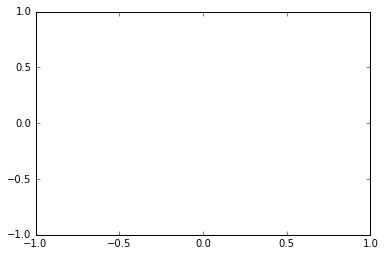

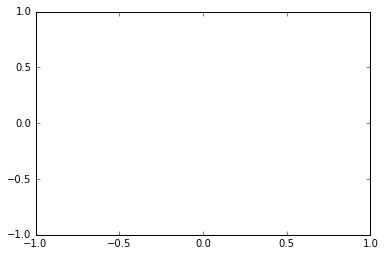

In [203]:
pos = x[3]
for n in range(nsteps):
    display.display(plt.clf());
    #plt.plot(*pos[n,:].T,'.',color='b');
    plt.xlim(-1,1);
    plt.ylim(-1,1);
    display.clear_output(wait=True);
    display.display(plt.gcf());

Lasagne's GRUlayer expects a three-dimensional input (batch_size,seq_len,dimension_of_signal)

In [204]:
X = x

In [205]:
X.shape

(10, 100, 2)

The output is supposed to be the next frame

In [206]:
x = np.zeros([5,9,100,50])
y = np.zeros([5,9,100,50])

In [207]:
x.shape,y.shape

((5, 9, 100, 50), (5, 9, 100, 50))

Lasagne also requires float32's for some reason (probably to save space)

In [208]:
x = x.astype(np.float32)
y = y.astype(np.float32)

Since Lasagne won't work with singular hidden units, the model has two, but we only use one in the cost function.

In [209]:
NUM_INPUTS = 1
NUM_UNITS_ENC = 30

In [210]:
#symbolic theano variables. Note that we are using imatrix for X since it goes into the embedding layer
x_sym = T.matrix()

In [211]:
x_sym = T.ftensor4()
y_sym = T.ftensor4()

First we try with a batch size of one, to test the code with long waiting times

In [212]:
#x_first = x[0:10,:].astype(np.float32)
#y_first = np.zeros([10,99,4]).astype(np.float32);
#y_first[0:10,:,0:1] = y[0:10,:,0:1].astype(np.float32);
#y_first = y[0:10,:,0].astype(np.float32)

#x_first = x[:,:].astype(np.float32)
#y_first = np.zeros([10,99,4]).astype(np.float32);
#y_first[:,:,0:1] = y[:,:,0:1].astype(np.float32);

#y = y_first;
#x = x_first;

In [213]:
#x_first.shape,y_first.shape
class DummyLayer(lasagne.layers.Layer):
    def __init__(self, incoming, shape, **kwargs):
        super(DummyLayer, self).__init__(incoming, **kwargs)
        self._shape = shape
    def get_output_for(self, input, **kwargs):
        #stupid workaround due to stupid python code-checking... Wish this was C++...
        return input.sum()*T.zeros(self._shape)
    def get_output_shape_for(self, input_shape):
        return (self._shape)

In [218]:
class OurLayer(lasagne.layers.CustomRecurrentLayer):
# Create single recurrent computation step function
    def __init__(self, incoming,
            nonlinearity=lasagne.nonlinearities.rectify,
            hid_init=lasagne.init.Constant(0.),
            backwards=False,
            learn_init=False,
            gradient_steps=-1,
            grad_clipping=0,
            unroll_scan=False,
            precompute_input=True,
            mask_input=None,
            only_return_final=False,
            num_layers=2,
            **kwargs):
        if isinstance(incoming, tuple):
            input_shape = incoming
        else:
            input_shape = incoming.output_shape
        
        #l_in_to_hid = lasagne.layers.DenseLayer(lasagne.layers.InputLayer((None,) + input_shape[2:]),num_units=num_layers)
        #l_hid_to_hid = lasagne.layers.DenseLayer(lasagne.layers.InputLayer(([None], num_layers)),num_units=num_layers)
        
        l_in_to_hid  = DummyLayer(lasagne.layers.InputLayer( ((input_shape[0]*input_shape[1]),input_shape[2:]              ) ),shape=((input_shape[0]*input_shape[1]), (input_shape[2]), (input_shape[3]), (num_layers)))
        l_hid_to_hid = DummyLayer(lasagne.layers.InputLayer( ((input_shape[0]*input_shape[1]), (input_shape[2]), (input_shape[3]), (num_layers)) ),shape=((input_shape[0]*input_shape[1]), (input_shape[2]), (input_shape[3]), (num_layers)))
        
        #l_test = lasagne.layers.ReshapeLayer(lasagne.layers.InputLayer((None,) + input_shape[2:]),shape=[100,50,5,9])
        
        print(l_hid_to_hid.input_shape)
        print(l_hid_to_hid.output_shape)
        
        print(l_in_to_hid.input_shape)
        print(l_in_to_hid.output_shape)
        
        #print( (None,) + input_shape[2:] )
        
        #make sure our parent works correctly:
        lasagne.layers.CustomRecurrentLayer.__init__(self,incoming,input_to_hidden=l_in_to_hid,hidden_to_hidden=l_hid_to_hid)
        #initialize our own data:
        self.num_layers=num_layers
        #figure out where to init hid_previous, hid_now
        self.has_inited_step = 0
        
    
    def get_output_for(self, inputs, **kwargs):
        """
        Compute this layer's output function given a symbolic input variable.
        Parameters
        ----------
        inputs : list of theano.TensorType
            `inputs[0]` should always be the symbolic input variable.  When
            this layer has a mask input (i.e. was instantiated with
            `mask_input != None`, indicating that the lengths of sequences in
            each batch vary), `inputs` should have length 2, where `inputs[1]`
            is the `mask`.  The `mask` should be supplied as a Theano variable
            denoting whether each time step in each sequence in the batch is
            part of the sequence or not.  `mask` should be a matrix of shape
            ``(n_batch, n_time_steps)`` where ``mask[i, j] = 1`` when ``j <=
            (length of sequence i)`` and ``mask[i, j] = 0`` when ``j > (length
            of sequence i)``. When the hidden state of this layer is to be
            pre-filled (i.e. was set to a :class:`Layer` instance) `inputs`
            should have length at least 2, and `inputs[-1]` is the hidden state
            to prefill with.
        Returns
        -------
        layer_output : theano.TensorType
            Symbolic output variable.
        """
        # Retrieve the layer input
        input = inputs[0]
        # Retrieve the mask when it is supplied
        mask = None
        hid_init = None
        if self.mask_incoming_index > 0:
            mask = inputs[self.mask_incoming_index]
        if self.hid_init_incoming_index > 0:
            hid_init = inputs[self.hid_init_incoming_index]

        # Input should be provided as (n_batch, n_time_steps, n_features)
        # but scan requires the iterable dimension to be first
        # So, we need to dimshuffle to (n_time_steps, n_batch, n_features)
        input = input.dimshuffle(1, 0, *range(2, input.ndim))
        seq_len, num_batch = input.shape[0], input.shape[1]

        if self.precompute_input:
            # Because the input is given for all time steps, we can precompute
            # the inputs to hidden before scanning. First we need to reshape
            # from (seq_len, batch_size, trailing dimensions...) to
            # (seq_len*batch_size, trailing dimensions...)
            # This strange use of a generator in a tuple was because
            # input.shape[2:] was raising a Theano error
            trailing_dims = tuple(input.shape[n] for n in range(2, input.ndim))
            input = T.reshape(input, (seq_len*num_batch,) + trailing_dims)
            input = helper.get_output(
                self.input_to_hidden, input, **kwargs)

            # Reshape back to (seq_len, batch_size, trailing dimensions...)
            trailing_dims = tuple(input.shape[n] for n in range(1, input.ndim))
            input = T.reshape(input, (seq_len, num_batch) + trailing_dims)

        # We will always pass the hidden-to-hidden layer params to step
        non_seqs = helper.get_all_params(self.hidden_to_hidden)
        # When we are not precomputing the input, we also need to pass the
        # input-to-hidden parameters to step
        if not self.precompute_input:
            non_seqs += helper.get_all_params(self.input_to_hidden)

        # Create single recurrent computation step function
        def step(input_n, hid_previous, *args):
            #assume input_n: array[N][M]
            #assume hid_previous: [N][M][3][num_layers]

            print('hello world')

            #assume hid_previous[:][:][1][i]: R on i'th layers.
            #assume hid_previous[:][:][2][i]: E on i'th layers.
            #assume hid_previous[:][:][3][i]: A on i'th layers.
            ##assume hid_previous[:][:][4][1]: Output image from previous state.

            N = hhh.shape.eval()[0]
            M = hhh.shape.eval()[1]

            #if (self.has_inited_step == 0):
            #    self.has_inited_step = 1
#            hid_previous = T.zeros([M,N,3,self.num_layers])
#
#            hid_now = T.zeros([M,N,3,self.num_layers])
#
#            #perform top to bottom operations:
#            for i in range(self.num_layers,1,-1):
#                #add data from layers:
#                if (i == self.num_layers):
#                    hid_now[:,:,1,i] = hid_previous[:,:,1,i] + hid_now[:,:,2,i]
#                else:
#                    hid_now[:,:,1,i] = hid_previous[:,:,1,i] + hid_now[:,:,2,i] + hid_now[:,:,1,i+1]
#
#            #perform bottom to top operations:
#            for i in range(1,self.num_layers):
#                #perform approximations.
#                if (i==1):
#                    #calculate A
#                    hid_now[:,:,3,i] = eval_fun_bot(hid_now[:,:,1,i])
#                    #calculate errors:
#                    hid_now[:,:,2,i] = hid_now[:,:,3,i] - input_n
#                else:
#                    #calculate A
#                    hid_now[:,:,3,i] = eval_fun(hid_now[:,:,1,i])
#                    #calculate errors:
#                    hid_now[:,:,2,i] = hid_now[:,:,3,i] - hid_now[:,:,2,i-1]

            return hid_previous

        def step_masked(input_n, mask_n, hid_previous, *args):
            # Skip over any input with mask 0 by copying the previous
            # hidden state; proceed normally for any input with mask 1.
            hid = step(input_n, hid_previous, *args)
            hid_out = T.switch(mask_n, hid, hid_previous)
            return [hid_out]

        if mask is not None:
            mask = mask.dimshuffle(1, 0, 'x')
            sequences = [input, mask]
            step_fun = step_masked
        else:
            sequences = input
            step_fun = step

        if not isinstance(self.hid_init, Layer):
            # The code below simply repeats self.hid_init num_batch times in
            # its first dimension.  Turns out using a dot product and a
            # dimshuffle is faster than T.repeat.
            dot_dims = (list(range(1, self.hid_init.ndim - 1)) +
                        [0, self.hid_init.ndim - 1])
            hid_init = T.dot(T.ones((num_batch, 1)),
                             self.hid_init.dimshuffle(dot_dims))

        if self.unroll_scan:
            # Retrieve the dimensionality of the incoming layer
            input_shape = self.input_shapes[0]
            # Explicitly unroll the recurrence instead of using scan
            hid_out = unroll_scan(
                fn=step_fun,
                sequences=sequences,
                outputs_info=[hid_init],
                go_backwards=self.backwards,
                non_sequences=non_seqs,
                n_steps=input_shape[1])[0]
        else:
            # Scan op iterates over first dimension of input and repeatedly
            # applies the step function
            hid_out = theano.scan(
                fn=step_fun,
                sequences=sequences,
                go_backwards=self.backwards,
                outputs_info=[hid_init],
                non_sequences=non_seqs,
                truncate_gradient=self.gradient_steps,
                strict=True)[0]

        # When it is requested that we only return the final sequence step,
        # we need to slice it out immediately after scan is applied
        if self.only_return_final:
            hid_out = hid_out[-1]
        else:
            # dimshuffle back to (n_batch, n_time_steps, n_features))
            hid_out = hid_out.dimshuffle(1, 0, *range(2, hid_out.ndim))

            # if scan is backward reverse the output
            if self.backwards:
                hid_out = hid_out[:, ::-1]

        return hid_out
    
    def eval_fun_bot(hid_now):
            return hid_now
    
    def eval_fun(hid_now):
        return hid_now
    

In [219]:
l_in = lasagne.layers.InputLayer((5,9,100,50), input_var = x_sym)

l_custom = OurLayer(l_in,num_layers=4)

l_in2 = lasagne.layers.InputLayer((5,9,100,50), input_var = x_sym)
l_dummy = DummyLayer(l_in2,shape=(5,9,100,50))

batch_size = 5,
seq_len = 9




#total error:
#l_out_total = lasagne.layers.ConcatLayer([l_out0],axis=3);
#l_out_total = lasagne.layers.ConcatLayer([l_out, l_out],axis=2);

# make sure output layer's range matches the range of input, fx with linear output layer
print(lasagne.layers.get_output(l_custom, inputs={l_in: x_sym}).eval({x_sym: x}).shape)
#print(lasagne.layers.get_output(l_dummy, inputs={l_in: x_sym}).eval({x_sym: x}).shape)

(45, 100, 50, 4)
(45, 100, 50, 4)
(45, (100, 50))
(45, 100, 50, 4)
hello world
(5, 9, 100, 50, 4)


In [19]:
print(lasagne.layers.get_all_params(l_out1))

[GRUEncoder.W_in_to_updategate, GRUEncoder.W_hid_to_updategate, GRUEncoder.b_updategate, GRUEncoder.W_in_to_resetgate, GRUEncoder.W_hid_to_resetgate, GRUEncoder.b_resetgate, GRUEncoder.W_in_to_hidden_update, GRUEncoder.W_hid_to_hidden_update, GRUEncoder.b_hidden_update, GRUEncoder.hid_init, GRUEncoder.W_in_to_updategate, GRUEncoder.W_hid_to_updategate, GRUEncoder.b_updategate, GRUEncoder.W_in_to_resetgate, GRUEncoder.W_hid_to_resetgate, GRUEncoder.b_resetgate, GRUEncoder.W_in_to_hidden_update, GRUEncoder.W_hid_to_hidden_update, GRUEncoder.b_hidden_update, GRUEncoder.hid_init, GRUEncoder.W_in_to_updategate, GRUEncoder.W_hid_to_updategate, GRUEncoder.b_updategate, GRUEncoder.W_in_to_resetgate, GRUEncoder.W_hid_to_resetgate, GRUEncoder.b_resetgate, GRUEncoder.W_in_to_hidden_update, GRUEncoder.W_hid_to_hidden_update, GRUEncoder.b_hidden_update, GRUEncoder.hid_init, W, b, GRUEncoder.W_in_to_updategate, GRUEncoder.W_hid_to_updategate, GRUEncoder.b_updategate, GRUEncoder.W_in_to_resetgate, GR

In [20]:
# cost function is mean absolute difference between predicted and actual next step.
predicted_values = lasagne.layers.get_output(l_custom)
cost = T.mean(abs(predicted_values - y_sym))

In [21]:
cost.eval({x_sym: x_first, p1_sym: x_first, y_sym: y_first})

array(0.1191576969708915)

In [22]:
all_parameters = lasagne.layers.get_all_params([l_out_total], trainable=True)
#add grad clipping to avoid exploding gradients
all_grads = [T.clip(g,-3,3) for g in T.grad(cost, all_parameters)]
#updates = lasagne.updates.adam(all_grads, all_parameters, learning_rate=0.001)
updates = lasagne.updates.adam(all_grads, all_parameters, learning_rate=0.005)

In [23]:
print("Trainable Model Parameters")
print("-"*40)
for param in all_parameters:
    print(param, param.get_value().shape)
print("-"*40)

Trainable Model Parameters
----------------------------------------
(GRUEncoder.W_in_to_updategate, (4, 30))
(GRUEncoder.W_hid_to_updategate, (30, 30))
(GRUEncoder.b_updategate, (30,))
(GRUEncoder.W_in_to_resetgate, (4, 30))
(GRUEncoder.W_hid_to_resetgate, (30, 30))
(GRUEncoder.b_resetgate, (30,))
(GRUEncoder.W_in_to_hidden_update, (4, 30))
(GRUEncoder.W_hid_to_hidden_update, (30, 30))
(GRUEncoder.b_hidden_update, (30,))
(GRUEncoder.W_in_to_updategate, (30, 30))
(GRUEncoder.W_hid_to_updategate, (30, 30))
(GRUEncoder.b_updategate, (30,))
(GRUEncoder.W_in_to_resetgate, (30, 30))
(GRUEncoder.W_hid_to_resetgate, (30, 30))
(GRUEncoder.b_resetgate, (30,))
(GRUEncoder.W_in_to_hidden_update, (30, 30))
(GRUEncoder.W_hid_to_hidden_update, (30, 30))
(GRUEncoder.b_hidden_update, (30,))
(GRUEncoder.W_in_to_updategate, (30, 30))
(GRUEncoder.W_hid_to_updategate, (30, 30))
(GRUEncoder.b_updategate, (30,))
(GRUEncoder.W_in_to_resetgate, (30, 30))
(GRUEncoder.W_hid_to_resetgate, (30, 30))
(GRUEncoder.b_

In [24]:
# compile training function (in C or somesuch)
train_func = theano.function([x_sym, p1_sym, y_sym], [cost, predicted_values], updates=updates)

In [25]:
c = 0
csts = []
preds = []
num_epochs = 300
pred = np.zeros(y.shape).astype(np.float32)
while c < num_epochs:
    cst, pred = train_func(x,pred[:,:,2:4],y)
    pred = pred.astype(np.float32)
    csts.append(cst)
    preds.append(pred)
    c += 1
    #print(c)

In [26]:
#while c < num_epochs*2:
#    cst, pred = train_func(x,pred[:,:,2,y)
#    csts.append(cst)
#    preds.append(pred)
#    c += 1
#    #print(c)

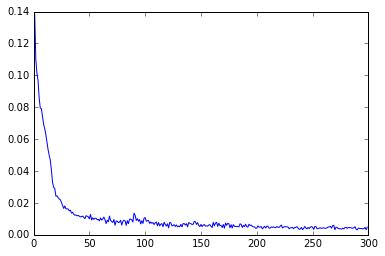

In [27]:
plt.plot(csts);

In [28]:
preds[-1][:,98,:]

array([[ -3.30022007e-01,   2.39323033e-03,  -6.83816150e-04,
          7.28454092e-04],
       [ -3.30848061e-02,  -5.66340692e-04,  -6.87962689e-04,
          7.47010927e-04],
       [  4.04509276e-01,  -4.89174901e-03,  -6.89219683e-04,
          7.61258998e-04],
       [  2.48251446e-02,  -5.68951364e-04,  -6.82977552e-04,
          7.20906304e-04],
       [  1.80862263e-01,  -1.83256902e-03,  -6.82967482e-04,
          7.19736330e-04],
       [ -5.85879564e-01,   3.88481794e-03,  -6.89419510e-04,
          7.65632372e-04],
       [ -4.87356514e-01,   3.73330247e-03,  -6.83429826e-04,
          7.22743338e-04],
       [ -1.11452654e-01,  -8.97417194e-04,  -6.85557025e-04,
          7.91857310e-04],
       [ -9.32332397e-01,   6.85461657e-03,  -6.91342924e-04,
          7.61493284e-04],
       [  1.90353766e-01,  -1.92231371e-03,  -6.82663172e-04,
          7.19182834e-04]], dtype=float32)

In [29]:
print(csts[-1])

0.00480437578088


Compare prediction generated by a randomly initialized network

In [30]:
preds[0].shape

(10, 99, 4)

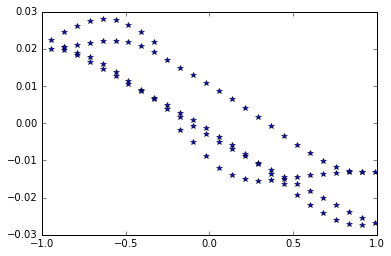

In [31]:
plt.plot(y_first[0,:,0].T.flatten(),preds[0][0,:,0].T.flatten(),'*')

to prediction by trained network (ideal is a straight line)

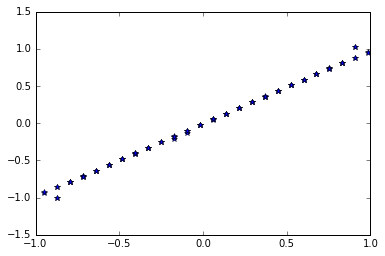

In [32]:
plt.plot(y_first[0,:,0].T.flatten(),preds[-1][0,:,0].T.flatten(),'*');

A few sample sequence comparisons:

In [33]:
sequence_idxs = np.random.choice(10,9,replace=False)

In [34]:
plt.rcParams['figure.figsize'] = (20,20)

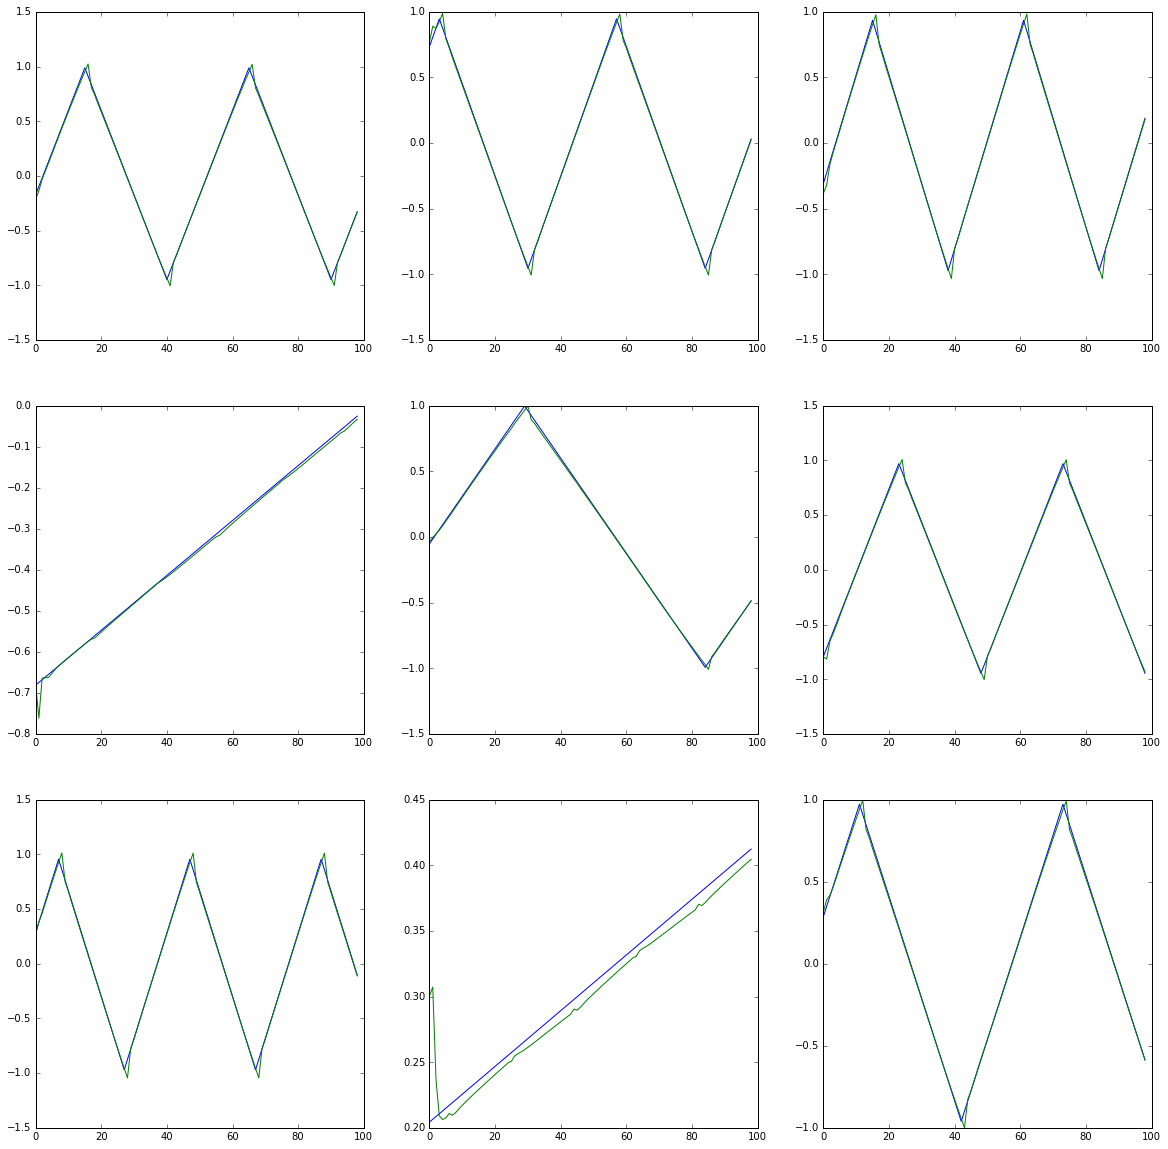

In [35]:
cc = 0
for i in sequence_idxs:
    cc += 1
    plt.subplot(3,3,cc)
    plt.plot(y_first[i,:,0].T)
    plt.plot(preds[-1][i,:,0].T)